# 03_Propagation-Based

In [1]:
import os
import cv2
import math
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
model = VGG16()
model.summary()

2022-05-24 17:36:04.850124: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-05-24 17:36:04.850927: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-05-24 17:36:04.851281: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with th

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [3]:
def load_imagenet_labels(labels_file):
    with open(labels_file) as reader:
        f = reader.read()
        labels = f.splitlines()
    return np.array(labels)

imagenet_labels = load_imagenet_labels('data/ImageNetLabels.txt')

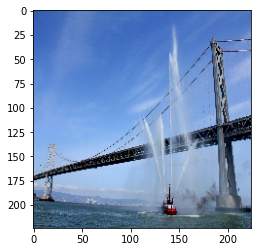

In [4]:
def read_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, size=(224, 224))
#     image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
    return image

image = read_image('data/fireboat.jpg')
plt.imshow(image/255)

In [5]:
def top_k_predictions(img, k=3):
    image_batch = tf.expand_dims(img, 0)
    inputs = preprocess_input(image_batch)
    predictions = model(inputs)
    top_probs, top_idxs = tf.math.top_k(input=predictions, k=k)
    top_labels = imagenet_labels[tuple(top_idxs)]
    return top_labels, top_idxs[0], top_probs[0]

In [6]:
pred_label, pred_idx, pred_prob = top_k_predictions(image)
for label, idx, prob in zip(pred_label, pred_idx, pred_prob):
    print(f'{label} ({idx}): {prob:0.1%}')

fireboat (554): 98.6%
drilling platform (540): 0.3%
crane (517): 0.2%


## [LRP (Bach et al. 15)](https://arxiv.org/abs/1604.00825)

In [7]:
import tensorflow.keras.backend as K
from tensorflow.python.ops import gen_nn_ops

def relprop_dense(x, w, r):
    w_pos = tf.maximum(w, 0.0)
    z = tf.matmul(x, w_pos) + 1.0e-9
    s = r / z
    c = tf.matmul(s, tf.transpose(w_pos))
    return c * x

def relprop_flatten(x, r):
    return tf.reshape(r, tf.shape(x))

def relprop_conv(x, w, r, name, strides=(1, 1, 1, 1), padding='SAME'):
    if name == 'block1_conv1':
        x = tf.ones_like(x)     # only for input

    w_pos = tf.maximum(w, 0.0)
    z = tf.nn.conv2d(x, w_pos, strides, padding) + 1.0e-9
    s = r / z
    c = tf.compat.v1.nn.conv2d_backprop_input(tf.shape(x), w_pos, s, strides, padding)
    return c * x

In [8]:
weights = {weight.name.split('/')[0]: weight for weight in model.trainable_weights if 'bias' not in weight.name}
activations = [layer.output for layer in model.layers]
activations = activations[::-1]
layer_names = [layer.name for layer in model.layers]
layer_names = layer_names[::-1]

In [9]:
relevance = model.output
for i, layer_name in enumerate(layer_names):
    if 'prediction' in layer_name:
        relevance = relprop_dense(activations[i+1], weights[layer_name], relevance)
    elif 'fc' in layer_name:
        relevance = relprop_dense(activations[i+1], weights[layer_name], relevance)
    elif 'flatten' in layer_name:
        relevance = relprop_flatten(activations[i+1], relevance)
    elif 'pool' in layer_name:
        relevance = tf.keras.layers.UpSampling2D(size=(2,2))(relevance)
    elif 'conv' in layer_name:
        relevance = relprop_conv(activations[i+1], weights[layer_name], relevance, layer_name)
    elif 'input' in layer_name:
        pass
    else:
        raise Exception("Error: layer type not recognized.")

In [10]:
f = K.function(inputs=model.input, outputs=relevance)

In [11]:
image_batch = tf.expand_dims(image, 0)
inputs = preprocess_input(image_batch)
relevance_scores = f(inputs)

In [12]:
def rescale(x):
    x_min = np.min(x, axis=(1, 2), keepdims=True)
    x_max = np.max(x, axis=(1, 2), keepdims=True)
    return (x - x_min).astype("float64") / (x_max - x_min).astype("float64")

In [13]:
attribution_mask = tf.reduce_sum(tf.math.abs(tf.squeeze(rescale(relevance_scores))), axis=-1)

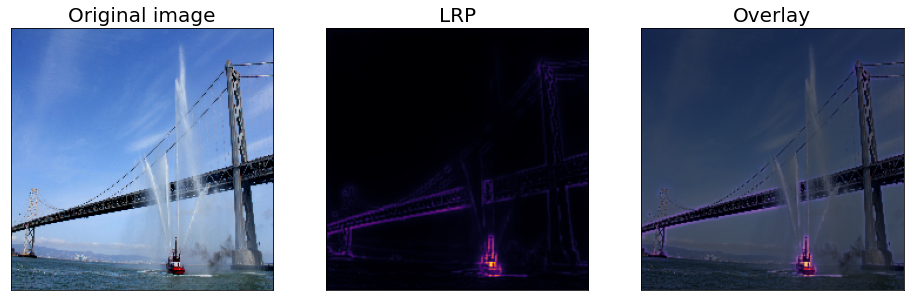

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 8),
                        subplot_kw={'xticks':[], 'yticks':[]})

axs[0, 0].set_title('Original image', fontsize=20)
axs[0, 0].imshow(image/255)

axs[0, 1].set_title('LRP', fontsize=20)
axs[0, 1].imshow(attribution_mask, cmap=cm.inferno)

axs[0, 2].set_title('Overlay', fontsize=20)
axs[0, 2].imshow(attribution_mask, cmap=cm.inferno)
axs[0, 2].imshow(image/255, alpha=0.4)

### 包成一個函數，方便呼叫

In [17]:
def lrp(image, model):

    weights = {weight.name.split('/')[0]: weight for weight in model.trainable_weights if 'bias' not in weight.name}
    activations = [layer.output for layer in model.layers]
    activations = activations[::-1]
    layer_names = [layer.name for layer in model.layers]
    layer_names = layer_names[::-1]
    
    relevance = model.output
    for i, layer_name in enumerate(layer_names):
        if 'prediction' in layer_name:
            relevance = relprop_dense(activations[i+1], weights[layer_name], relevance)
        elif 'fc' in layer_name:
            relevance = relprop_dense(activations[i+1], weights[layer_name], relevance)
        elif 'flatten' in layer_name:
            relevance = relprop_flatten(activations[i+1], relevance)
        elif 'pool' in layer_name:
            relevance = tf.keras.layers.UpSampling2D(size=(2,2))(relevance)
        elif 'conv' in layer_name:
            relevance = relprop_conv(activations[i+1], weights[layer_name], relevance, layer_name)
        elif 'input' in layer_name:
            pass
        else:
            raise Exception("Error: layer type not recognized.")
            
    f = K.function(inputs=model.input, outputs=relevance)
    
    image_batch = tf.expand_dims(image, 0)
    inputs = preprocess_input(image_batch)
    relevance_scores = f(inputs)

    return relevance_scores

In [18]:
relevance_scores = lrp(image, model)
attribution_mask = tf.reduce_sum(tf.math.abs(tf.squeeze(rescale(relevance_scores))), axis=-1)

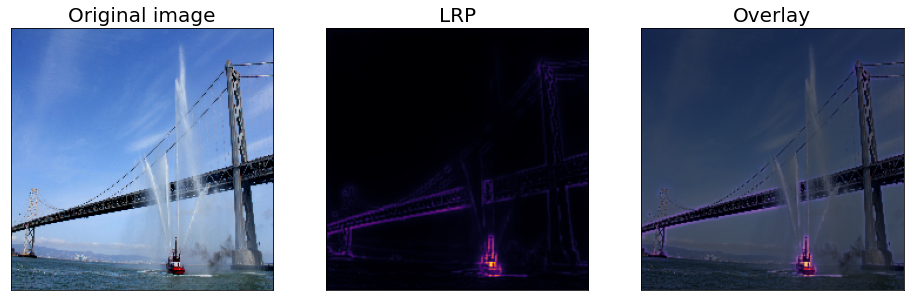

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 8),
                        subplot_kw={'xticks':[], 'yticks':[]})

axs[0, 0].set_title('Original image', fontsize=20)
axs[0, 0].imshow(image/255)

axs[0, 1].set_title('LRP', fontsize=20)
axs[0, 1].imshow(attribution_mask, cmap=cm.inferno)

axs[0, 2].set_title('Overlay', fontsize=20)
axs[0, 2].imshow(attribution_mask, cmap=cm.inferno)
axs[0, 2].imshow(image/255, alpha=0.4)

### 練習時間：
#### 試試看用不同影像 (data/cat.jpeg) 來跑這個方法。 